In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import re

from functions.Connectivity import *
# from functions.Connectivity import calculate_and_plot_granger_causality
from scipy.signal import hilbert

from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq

In [18]:
main_path='/home/pablo/works/dev_thesis_SEEG/data/mainDatabase_patients/'
patient_name='sub-HUP142'
ref_data=0
# Document with file data
doc_file_data=pd.read_csv(main_path+'/'+patient_name+'/'+'ses-presurgery/'+patient_name+'_ses-presurgery_scans.tsv',sep='\t')

# Load the data

raw=mne.io.read_raw_edf(main_path+'/'+patient_name+'/'+'ses-presurgery/'+doc_file_data['filename'][ref_data],preload=True)
xyz_loc=pd.read_csv(main_path+'/'+patient_name+'/'+'ses-presurgery/ieeg/'+patient_name+'_ses-presurgery_acq-seeg_space-fsaverage_electrodes.tsv',sep='\t')
events=pd.read_csv(main_path+'/'+patient_name+'/'+'ses-presurgery/'+doc_file_data['filename'][ref_data].replace('_ieeg.edf','_events.tsv'),sep='\t')
channels=pd.read_csv(main_path+'/'+patient_name+'/'+'ses-presurgery/'+doc_file_data['filename'][ref_data].replace('_ieeg.edf','_channels.tsv'),sep='\t')


Extracting EDF parameters from /home/pablo/works/dev_thesis_SEEG/data/mainDatabase_patients/sub-HUP142/ses-presurgery/ieeg/sub-HUP142_ses-presurgery_task-ictal_acq-seeg_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 132607  =      0.000 ...   258.998 secs...


In [19]:
#Inside_network
good_channels=channels[channels['status']=='good']
inside_network=list(good_channels[(good_channels['status_description'] == 'resect') |
    (good_channels['status_description'] == 'soz') |
    (good_channels['status_description'] == 'resect,soz') |
    (good_channels['status_description'] == 'soz,resect')
]['name'])
good_channels=list(good_channels['name'])
xyz_loc=xyz_loc[['name','x','y','z']]
xyz_loc.columns = ['formatted_label','r','a','s']
#Select those who are good channels
xyz_loc=xyz_loc[xyz_loc['formatted_label'].isin(good_channels)].reset_index(drop=True)

In [20]:
crisis_center=float(events['onset'][0])  #Getting the first onset event
# Define the time window
tmin=crisis_center-30
tmax=crisis_center+30
raw_f=raw.copy().crop(tmin=tmin, tmax=tmax)

In [21]:
# Channel Formating

#Find intersection of xyz_loc['formatted_label'] and epochs.ch_names
intersection = set(xyz_loc['formatted_label']).intersection(raw.ch_names)

# Filter the dataframe to keep only the intersecting labels
df_filtered = xyz_loc[xyz_loc['formatted_label'].isin(intersection)]

# Reorder the dataframe according to chnames (which will now only contain the intersecting labels)
df_filtered = df_filtered.set_index('formatted_label')

#Getting to know which inndexes from the original to eliminate 
cd=pd.Series(raw.ch_names).isin(intersection)
idx=cd.index[~cd].tolist()

#Eliminating the channels which are not in the intersection

channels_to_drop=[raw.ch_names[item] for item in idx]

raw.drop_channels(channels_to_drop)

xyz_loc = xyz_loc.set_index('formatted_label').reindex(raw.ch_names).reset_index()

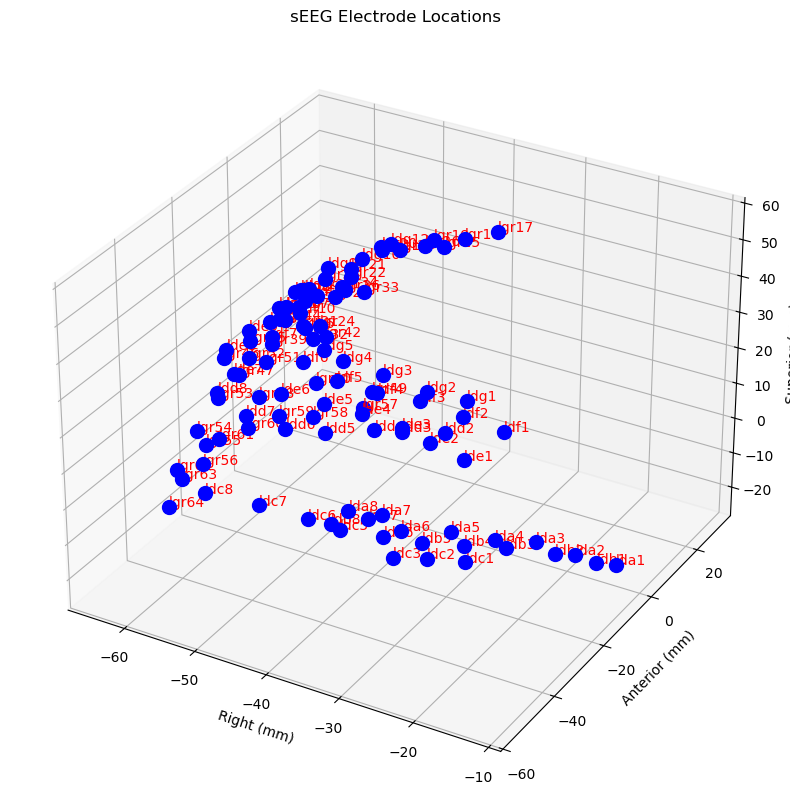

In [22]:
#Plot the electrodes ubications in a x,y,z 3D space
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each electrode as a point
for i, row in xyz_loc.iterrows():
    ax.scatter(row['r'], row['a'], row['s'], color='b', s=100)

# Annotate each electrode with its name, without the "EEG" prefix and lowercase
for i, row in xyz_loc.iterrows():
    ax.text(row['r'], row['a'], row['s'], row['formatted_label'].lower(), color='r')
# Set labels and title
ax.set_xlabel('Right (mm)')
ax.set_ylabel('Anterior (mm)')
ax.set_zlabel('Superior (mm)')
ax.set_title('sEEG Electrode Locations')

plt.show()

In [29]:
#####

mni2fsavg_file = "/home/pablo/works/dev_thesis_SEEG/New_data/Code/mni2fsaverage.npy"
mni2fsavg = np.load(mni2fsavg_file)
#Montage transformation 
# Prepare the dictionary for digitized montage
ch_pos = {}
xyz_loc_copy = xyz_loc.copy()
for _, row in xyz_loc.iterrows():
    # Original coordinates (in meters)
    original_point = np.array([row['r'], row['a'], row['s'], 1])  # Homogeneous
    
    # Transform the point
    transformed_point = mni2fsavg @ original_point
    transformed_point = transformed_point
    # Drop the homogeneous coordinate (last element)
    ch_pos[row['formatted_label']] = transformed_point[:3]
    #New coordinates
    xyz_loc_copy.loc[xyz_loc_copy['formatted_label'] == row['formatted_label'], ['r', 'a', 's']] = transformed_point[:3]


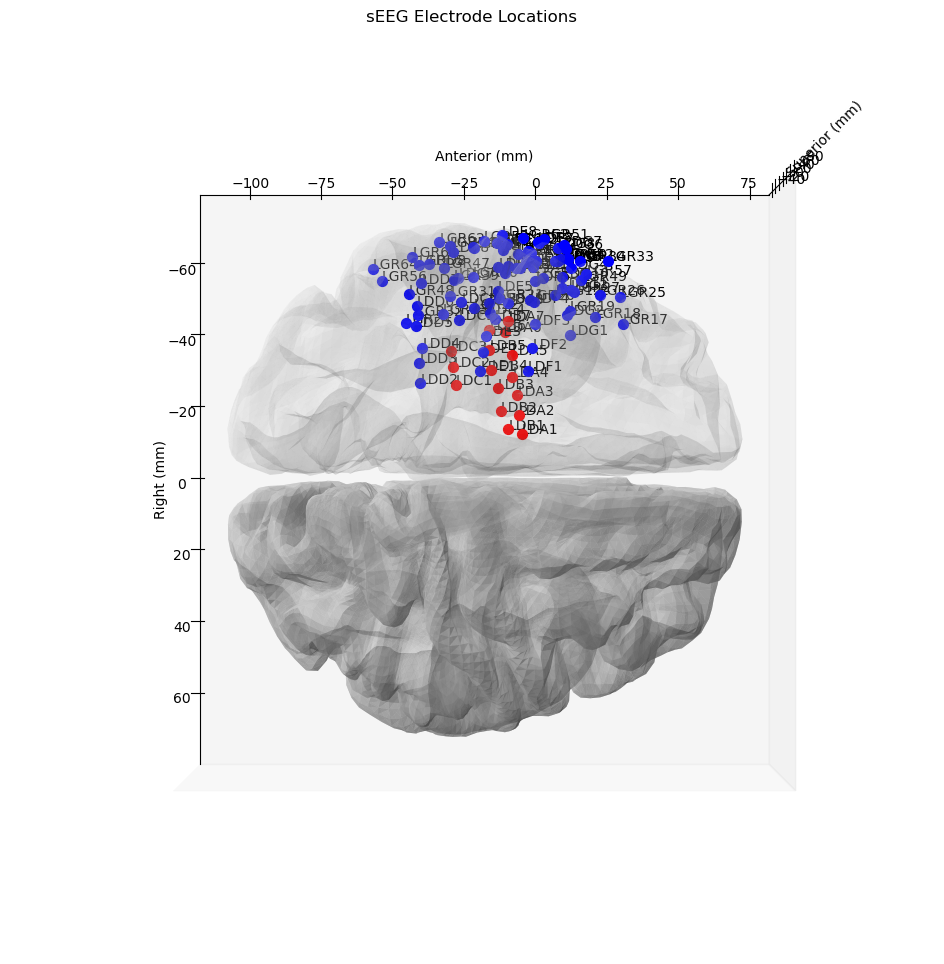

Electrode locations plotted


In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nibabel as nib
from nilearn import datasets
import pandas as pd


# Load fsaverage template (high-res pial surface)
fsaverage = datasets.fetch_surf_fsaverage()
left_mesh_file = fsaverage.pial_left  # Pial surface of the left hemisphere
right_mesh_file = fsaverage.pial_right  # Pial surface of the right hemisphere

# Load the meshes using nibabel
left_mesh = nib.load(left_mesh_file)
right_mesh = nib.load(right_mesh_file)

left_coords = left_mesh.darrays[0].data  # Coordinates
left_faces = left_mesh.darrays[1].data  # Faces (triangles)

right_coords = right_mesh.darrays[0].data
right_faces = right_mesh.darrays[1].data

# Create 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot left hemisphere
ax.plot_trisurf(left_coords[:, 0], left_coords[:, 1], left_coords[:, 2], 
                triangles=left_faces, color='lightgray', alpha=0.1)

# Plot right hemisphere
ax.plot_trisurf(right_coords[:, 0], right_coords[:, 1], right_coords[:, 2], 
                triangles=right_faces, color='lightgray', alpha=0.5)

# Plot electrodes
for i, row in xyz_loc_copy.iterrows():
    color = 'red' if row['formatted_label'] in inside_network else 'blue'
    ax.scatter(row['r'], row['a'], row['s'], color=color, s=50)
    ax.text(row['r'], row['a'], row['s'], row['formatted_label'], color='black')
    # ax.scatter(row['r'], row['a'], row['s'], color='blue', s=50)
    # ax.text(row['r'], row['a'], row['s'], row['formatted_label'], color='black')

# Set axis labels and title
ax.set_xlabel('Right (mm)')
ax.set_ylabel('Anterior (mm)')
ax.set_zlabel('Superior (mm)')
ax.set_title('sEEG Electrode Locations')

# Adjust view and plot settings
ax.view_init(azim=0, elev=90)  # Rotate for better view
ax.grid(False)
plt.show()

print('Electrode locations plotted')